In [62]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import eit
import pandas as pd
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='cm')

In [82]:
root_path = 'results/temporal_recovery_'
run_ids = ['n=5_5b47c487', 'n=5_aab75251', 'n=6_bebc881d']

In [126]:
plot_means = []
for run_id in run_ids:
    root_dir = root_path + run_id
    with open(os.path.join(root_dir, 'results.pkl')) as f:
        results = pickle.load(f)
    summary = pd.read_csv(os.path.join(root_dir, 'summary.csv'))
    params_dict = {}
    with open(os.path.join(root_dir, 'params.py')) as f:
        exec(f.read(), {}, params_dict)
        
    lamb = params_dict['lamb']
    temps = params_dict['intermediate_temperatures']
    indices = np.arange(temps, len(results), temps+1, dtype=np.int)
    
    names = summary.iloc[indices].Kernel_Name
    # print names
    frames = [results[i] for i in indices]
    weights = [pd.read_csv(os.path.join(root_dir, 'detailed_summaries', n + '.csv')).Weights for n in names]
    to_plot = [np.average(np.exp(f), weights=w, axis=0) for f, w in zip(frames, weights)]
    
    plot_means.append(to_plot)
    lambdas.append(lamb)

In [127]:
max_level = np.max([np.max(m) for lamb in plot_means for m in lamb])
min_level = np.min([np.min(m) for lamb in plot_means for m in lamb])
levels = np.linspace(min_level, max_level, 20)

In [128]:
proposal_design = eit.grids.construct_shell(np.linspace(0,1,params_dict['n_radii_inverse']))

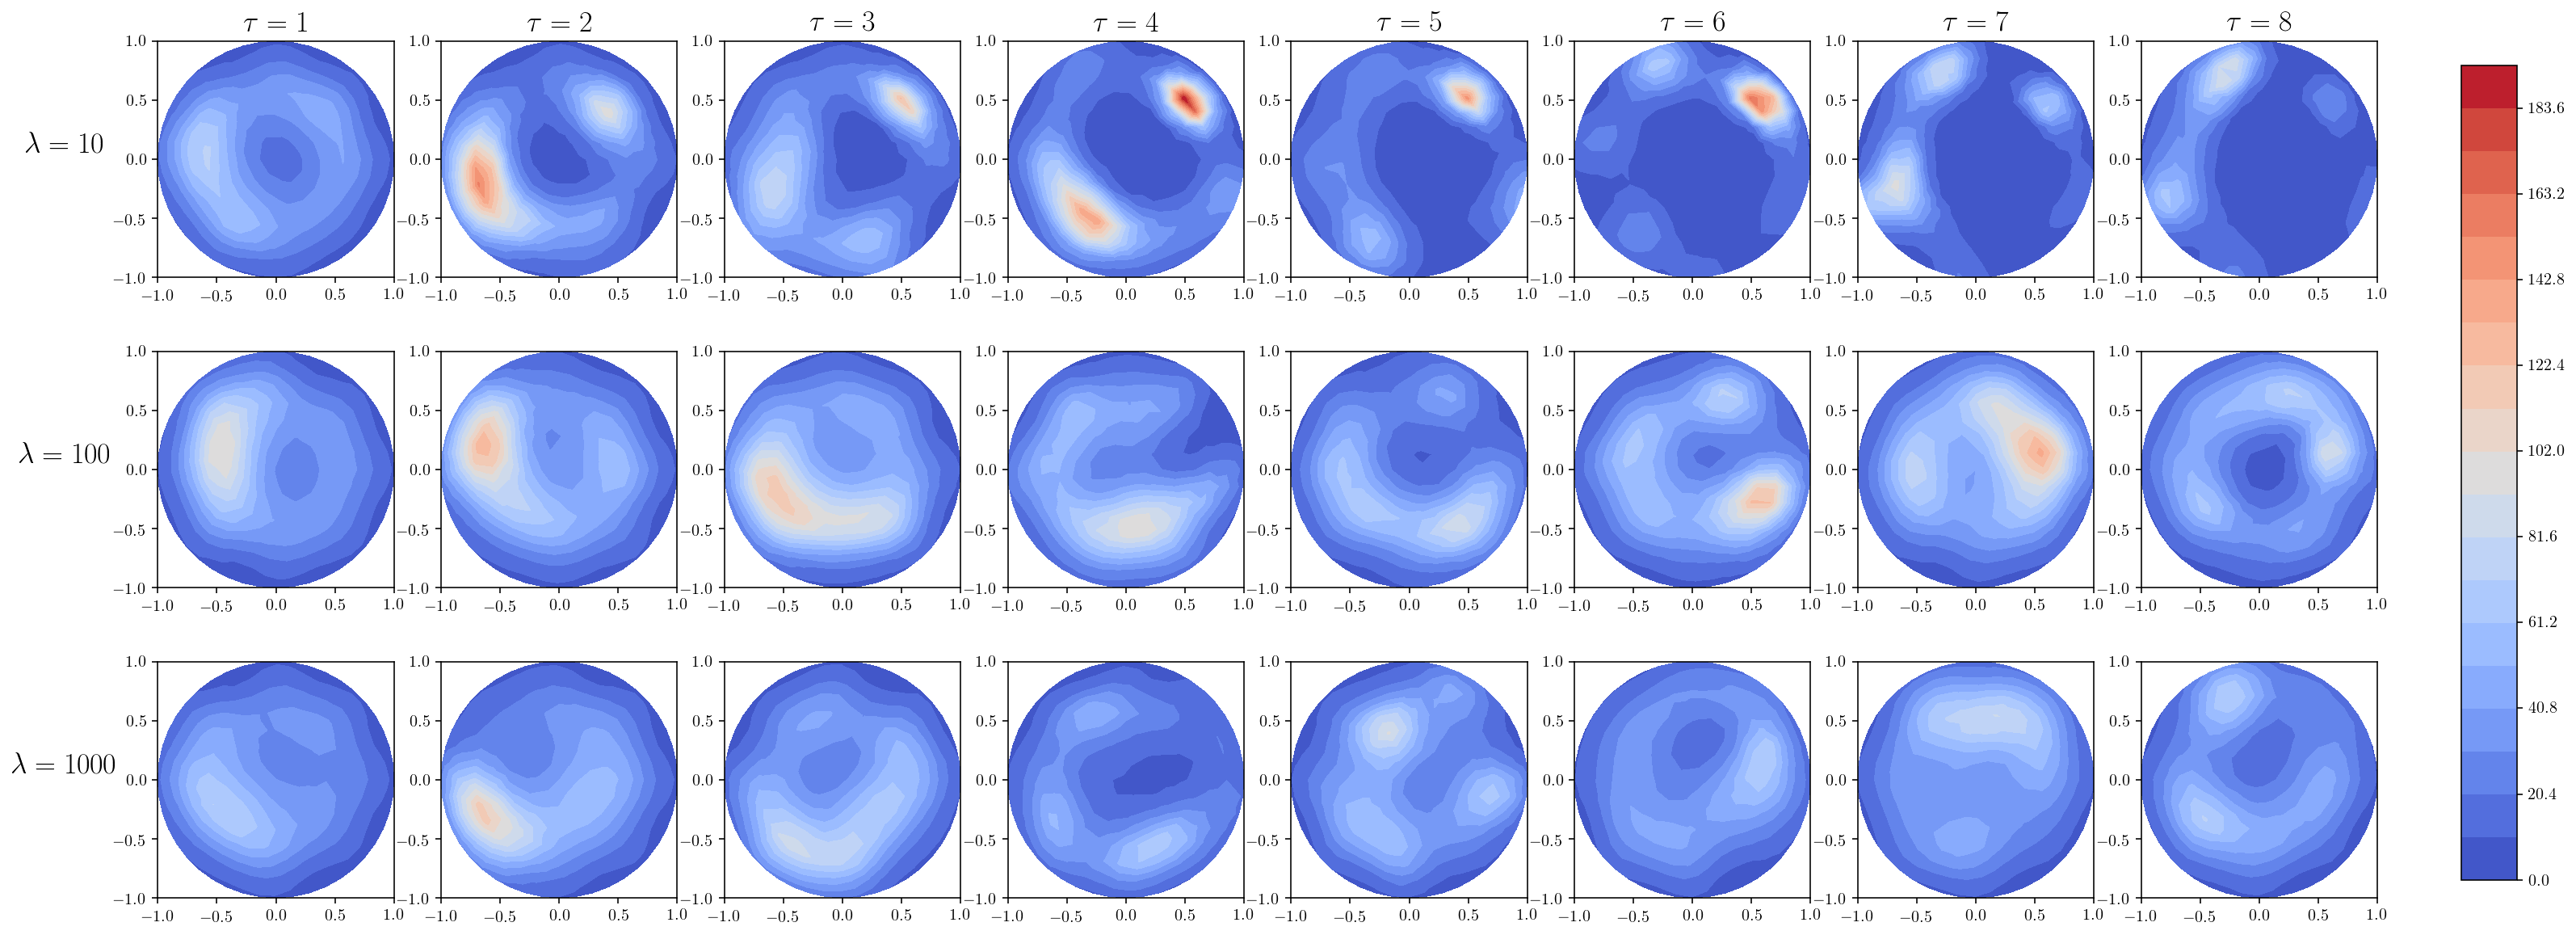

In [137]:
fig, axes = plt.subplots(len(plot_means), len(plot_means[0]), figsize=(24,10))
raveled = [a for a1 in axes for a in a1]
frame_ixs = np.arange(1, 1+len(to_plot))
for i in xrange(len(plot_means)):
    sub_axes = axes[i]
    plot_row = plot_means[i]
    for mean, axis, frame in zip(plot_row, sub_axes, frame_ixs):
        im = axis.tricontourf(proposal_design[:,0], proposal_design[:,1], mean, levels, cmap='coolwarm')
        axis.set_aspect('equal')

for axis, frame in zip(axes[0], frame_ixs):
    axis.set_title(r'$\tau={}$'.format(frame), fontsize=18)
    
for axis, lamb in zip(axes[:,0], lambdas):
    axis.set_ylabel(r'$\lambda={:.0f}$'.format(lamb), rotation=0, fontsize=18, labelpad=30)
    
#fig.tight_layout()
fig.subplots_adjust(right=0.92)
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax)
plt.savefig('figures/temporal_recovery_lambdas.pdf'.format(run_id), bbox_inches='tight', transparent=True, )

In [72]:
with open(os.path.join(compare_dir, 'results.pkl')) as f:
    compare_results = pickle.load(f)

compare_frames = [compare_results[i] for i in indices]

In [76]:
variances = [np.mean(np.std(np.exp(f), axis=0)) for f in frames]
compare_variances = [np.mean(np.std(np.exp(f), axis=0)) for f in compare_frames]

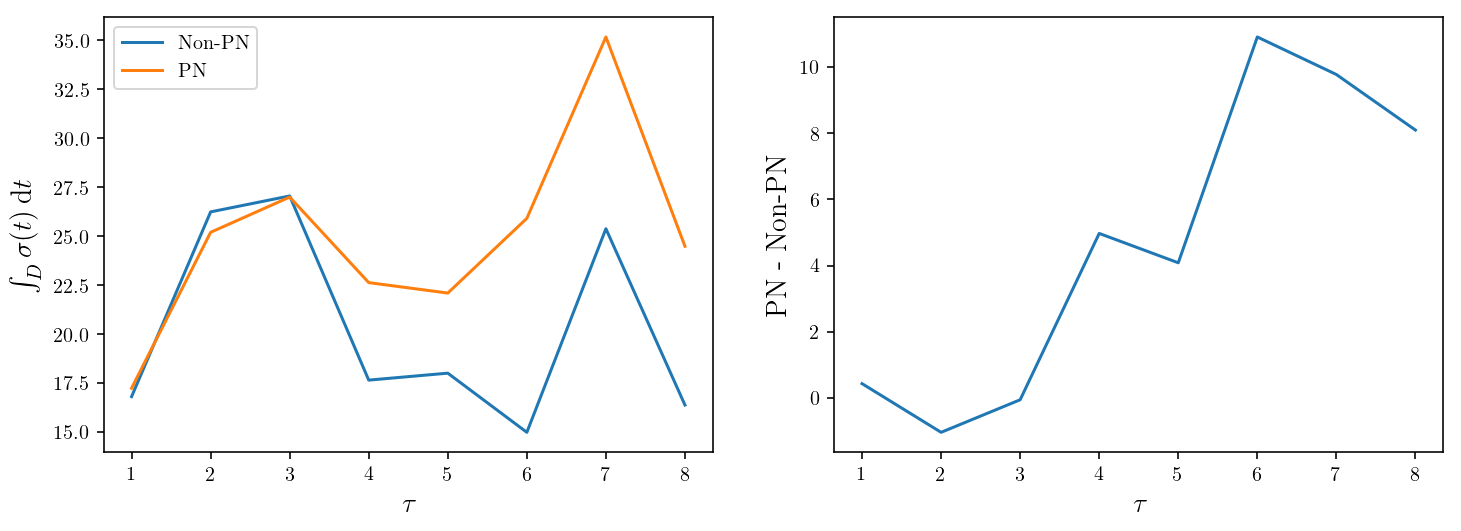

In [80]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(frame_ixs, compare_variances, label='Non-PN')
plt.plot(frame_ixs, variances, label='PN')
plt.xlabel(r'$\tau$', fontsize=14)
plt.ylabel(r'$\int_D \sigma(t) \:\textrm{d}t$', fontsize=14)
plt.legend()
plt.subplot(122)
plt.plot(frame_ixs, np.array(variances) - np.array(compare_variances))
plt.xlabel(r'$\tau$', fontsize=14)
plt.ylabel(r'PN - Non-PN', fontsize=14)
plt.savefig('figures/temporal_recovery_variance_{}.pdf'.format(run_id), bbox_inches='tight', transparent=True)

In [ ]:
variances[0] - compare_variances[0]